# Plot prediction vs real value for training data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import cloudpickle as cpkl

import os
import sys
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append('../art')
sys.path.append('../notebooks')
import auxiliary_functions
import itertools

import art.plot as aplt
from art.plot import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Import trained art model

In [2]:
art_file = './output/art.cpkl'
with open(art_file, 'rb') as output:
        art = cpkl.load(output)

Create 2 functions to edit the default functionality of ART plotting.

In [3]:
def predictions_vs_observations(
    art,
    cv: bool = True,
    error_bars: bool = False,
    X_test: np.ndarray | None = None,
    y_test: np.ndarray | None = None,
    x_limits: Sequence[ViewLimits] | None = None,
    y_limits: Sequence[ViewLimits] | None = None,
    log: bool = False,
    cv_flag: bool = True,
    errorbars_flag: bool = False,
    observed_test: np.ndarray | None = None,
    xlim: Sequence[ViewLimits] | None = None,
    ylim: Sequence[ViewLimits] | None = None,
):
    """
    Plots predictions vs observations for a RecommendationEngine machine learning model.

    For each response variable, creates a scatter plot of machine learning model predictions vs.
    actual values from the data set along with a diagonal line showing where perfect agreement
    would be.

    :param art: A RecommendationEngine instance to gather input from and to use in computing
        statistics.
    :param cv: True to use cross-validated model accuracy statistics in the plot labels, False
        to use non cross-validated accuracy statistics.
    :param error_bars: True to include error bars in the plots.
    :param errorbars: DEPRECATED alias for error_bars.
    :param X_test: Input variable values from the data set which represent ground truth.
        These values are included in the plot in a different color, if provided.  A 2D array of
        input data with shape (# observations, # input_vars). If X_test is provided, you must also
        provide Y_test.
    :param y_test: The set of response variable values from the data set which represent ground
        truth, corresponding to X_test.  These values are included in the plot in a different
        color, if provided.  A 2D array of response data with shape
        (# observations, # response_vars)
    :param observed_test: DEPRECATED. use y_test instead, which is equivalent.
    :param x_limits: Optional view limits for the plot's x-axis.  For each response variable,
        a tuple of (left limit, right limit).
    :param xlim: DEPRECATED alias for x_limits.
    :param y_limits: Optional view limits for the plot's y-axis. For each response variable,
        a tuple of (bottom limit, top limit).
    :param ylim: DEPRECATED alias for y_limits.
    :param log: True to create a log-log plot.
    """

    # Apply deprecations to renamed parameters
    cv = aplt._apply_cv_flag_deprecation(cv_flag, cv)
    error_bars = aplt._apply_errorbars_deprecation(errorbars_flag, error_bars)
    y_test = aplt._apply_observed_test_deprecation(y_test, observed_test)
    x_limits, y_limits = aplt._apply_limit_deprecations(x_limits, y_limits, xlim, ylim)

    # Test input model state / array shapes to prevent cryptic errors later
    aplt._test_art_model_state(art, cv)
    aplt._test_pred_vs_obs_array_shapes(art, X_test, y_test)
    aplt._test_limits_shapes(art.response_vars, x_limits, y_limits)

    # Choose / compute posterior predictive stats
    predicted_stats = aplt._choose_post_pred_stats(art, cv)
    predicted_stats_test = None
    if X_test is not None:
        predicted_stats_test = art.post_pred_stats(X_test)

    # Gather inputs from ART
    output_dir = art.output_dir
    model_df = art.model_df
    if cv:
        model_df = art.model_df_cv
    plot_inputs = aplt._PredictionVsObservationPlots(
        response_vars=art.response_vars,
        model_df=model_df,
        predicted_stats=predicted_stats,
        predicted_stats_test=predicted_stats_test,
        X_test=X_test,
        Y=art.loader.load_response_data(),
        y_test=y_test,
    )
    options = aplt._PlotOptions(cv, error_bars, log)

    for j in range(len(art.response_vars)):
        # Extract plot inputs for this response variable
        response_plot_data = plot_inputs.get_response_data(j)

        # Build, show & save the response variable plot
        f_out = plot_pred_vs_obs__single_response_var(
            data=response_plot_data,
            options=options,
            output_dir=output_dir,
            xlim=x_limits[j] if x_limits else None,
            ylim=y_limits[j] if y_limits else None,
        )
    return f_out

        
def plot_pred_vs_obs__single_response_var(
    data: aplt._SinglePredictionsVsObservationsPlot,
    output_dir: Path,
    options: aplt._PlotOptions,
    xlim: ViewLimits,
    ylim: ViewLimits,
):
    """
    Builds, shows, and saves a predictions vs observations plot for a single response variable.
    """

    # Temporarily set stylesheet used for this plot without modifying global state.
    # This prevents cross-contamination between plots, e.g. during unit testing.
    with plt.style.context('default'):
        fig, ax = plt.subplots(figsize=(7, 7))

        # Optionally plot error bars
        if options.error_bars:
            plt.errorbar(
                data.Y,
                data.predicted_mean,
                yerr=std_interval * data.predicted_std,
                fmt="ko",
                ecolor="gray",
                elinewidth=1,
                alpha=0.8,
            )
            if data.y_test is not None:
                plt.errorbar(
                    data.y_test,
                    data.predicted_mean_test,
                    yerr=data.predicted_std_test,
                    ecolor="b",
                    fmt="ko",
                    alpha=0.5,
                )
        # Plot just scatter data
        else:
            plt.scatter(data.Y, data.predicted_mean, color="k")
            if data.y_test is not None:
                plt.scatter(data.y_test, data.predicted_mean_test, color="b")

        # Label axes with context & summary stats
        fontsize = 20
        ax.set_title(f"$R^2$={data.r2}, MAE={data.mae}", fontsize=fontsize)
        ax.set_xlabel("Observations", fontsize=fontsize)
        if options.cv:
            ax.set_ylabel("Cross-validated predictions", fontsize=fontsize)
        else:
            ax.set_ylabel("Predictions", fontsize=fontsize)

        # Set view limits for the plot
        aplt._set_view_limits(ax, xlim, ylim)

        # Plot diagonal dashed Line
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, ls="--", color=".8", zorder=0)

        # Show the plot
        plt.tick_params(axis="both", which="major", labelsize=fontsize)
        plt.show()

        return fig

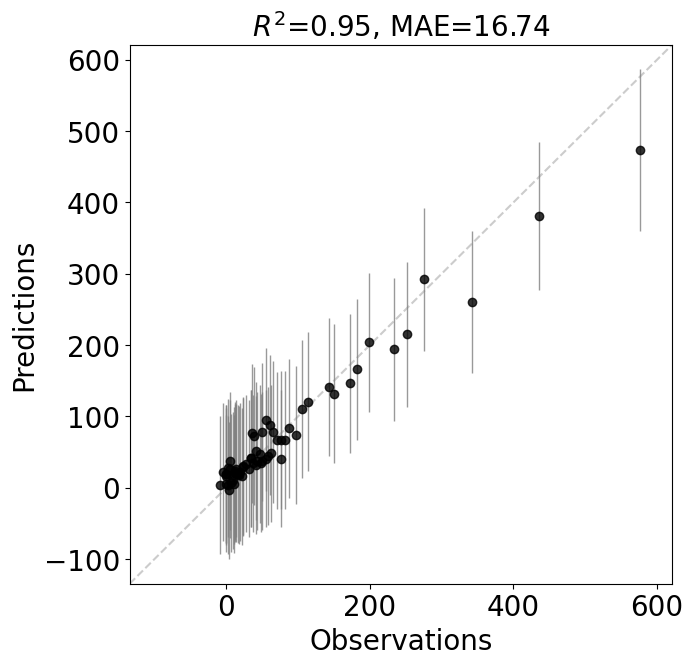

In [4]:
f = predictions_vs_observations(art, error_bars = True, cv = False)

In [5]:
f.savefig(fname = './figures/pred_vs_obs_vec.png', bbox_inches = 'tight')
f.savefig(fname = './figures/pred_vs_obs_vec.pdf', bbox_inches = 'tight')